# Monte Carlo and Jump Diffustion

This notebook is designed to implement two models used to predict the price of a stock in the future. In this notebook, the two models are a simple Monte Carlo using GBM and a Jump Diffusion Model. The notebook does the following:
1. Collects historical data from Yahoo Finance using the python module yfinance.
2. Runs a GMB Monte Carlo simulation on the stock using the historical data.
3. Gives a small analysis of the data from the Monte Carlo simulation
4. Test how the model would perform for the stock in the year leading up to the current day.
5. Runs a Jump Diffusion model with the historical data/gives a small analysis.
6. Gives a comparison of the GBM and Jump Diffusion models. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
import yfinance as yf
import math as m
from scipy.stats import norm
import scipy.stats as st

## Collecting Data

First, we collect the data. The program asks the user for a stock they want to see modeled. The program then collects the historical data (3 years worth) from Yahoo Finace using the yfinance package. Different aspects of the data is then displayed, like the closing price from each day over the past 3 years. Along with this the percent change of the closes and the log of the percnent changes with one added on is displayed. The log percent change ensures a Normal distribution and allows for compound changes. 

In [2]:
ticker = input("What stock would you like to predict ->").upper()
total = 3 * 365 # total days for histrorical data
trade_days = 252 # number of trading days in a year
n = 10000 # number of simulations

In [3]:
stock = yf.Ticker(ticker)
date_start = dt.date.today() - dt.timedelta(days = total)
data = stock.history(start = date_start)
data = data.drop(columns=['Volume','Dividends','Stock Splits'])


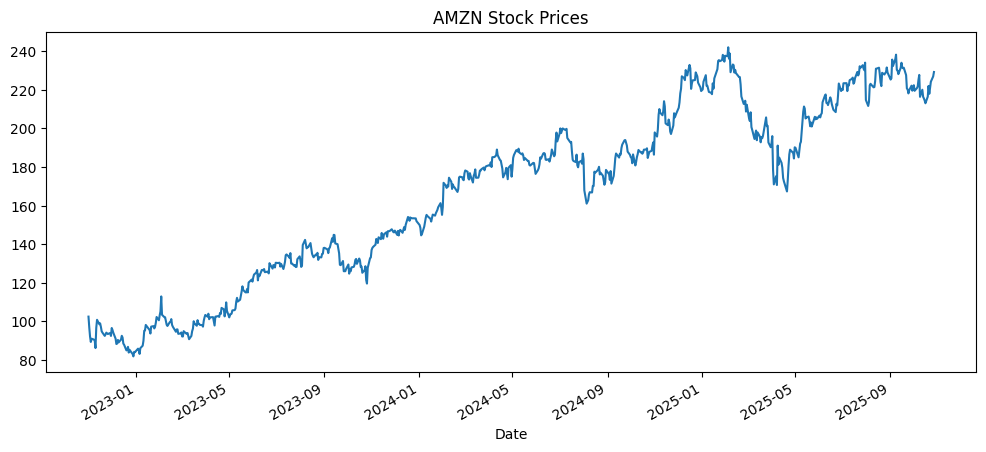

In [4]:
data["Close"].plot(figsize= (12,5))
plt.title(f"{ticker} Stock Prices")
plt.show()

In [5]:
data["Percent Change"] = data["Close"].pct_change() 
data["Log Change"] = np.log(data['Percent Change'] + 1)

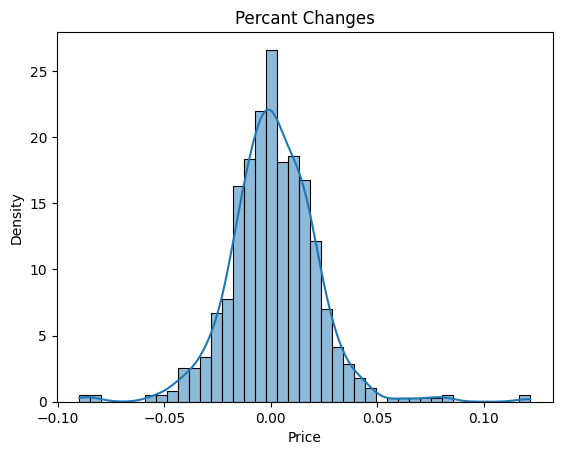

In [6]:
sns.histplot(data["Percent Change"], kde= True, bins='auto', stat='density')
plt.title("Percant Changes")
plt.xlabel("Price")
plt.show()

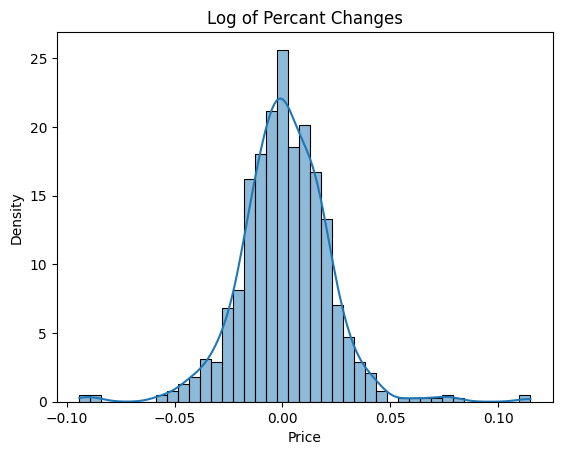

In [7]:
sns.histplot(data["Log Change"], kde= True, bins='auto', stat='density')
plt.title("Log of Percant Changes")
plt.xlabel("Price")
plt.show()

# Geometric Brownian Motion
The following methods are used in various aspects of the program. First, the method GBM is used to model the stocks proice for a year at default. To start, we assume that stock prices have a Log-Normal distribution, and hence, cannot be negative. 
Let $ \mu = E[\text{Log Percent Change}] $ and  $ \sigma^2 = Var(\text{Log Percent Change}) $.

Then Geometric Brownian Motion comes from the following Stochastic Differential Equation: 
$$ dS_t = \mu S_t dt + \sigma S_t dW_t $$
The solution to this SDE is:
$$ S_t = S_{t-1} * e^{drift + \sigma W_t} $$
Where $S_t$ is the price of day t, 
$drift = \mu - \frac{1}{2} \sigma^2 $ , and $W_t$ is the Wiener Process.
The Wiener Process is a Stochasic Process that takes a the distribution of a Normal Random Variable with mean of 0 and variance of t. In other words, $$ f_{W(t)} = \frac {1} {\sqrt{2 \pi t}} e^{-\frac {x^2} {2t}} $$

Since we are using equation for one day at a time with expected value and variance that was gathered from data for one day changes, $W_t$ becomes a Normal Distribution with a mean of zero and a variance of one. 

A random variable $Y$ is said to be Log-Normal with parameters $\mu$, $\sigma^2$ if $ Y = e^X $ where $X$ is a Normal Random Variable with parameters $\mu$ and $\sigma^2$. 

It is an interesting note that the product of Log-Normal Random Variable $\prod_{i = 1}^{n} Y_i$ where $Y_i$ has parameters $\mu_i$ and $\sigma_i^2$ and are independent, is Log-Normal with $\mu = \sum_{i = 1}^n \mu_i$ and $\sigma^2 = \sum_{i = 1}^n \sigma_i^2$

## Probability Over
This is used to find the probability that the Monte Carlo trials greater than the last closing price using 2 methods:
1. Counting the number greater and dividing by the total
2. Using a Log-Normal Approximation

## VaR_CVaR
Used to find the value at a given risk and the conditional value for a given risk. 
Since we are doing a Monte Carlo Simulation, this is defined as the getting the value a the risk amount percentile. 
CVaR is the conditional value at risk, which is defined as $E[\text{Trial Outcomes} \leq \text{Value at Risk}]$
VaR is also found using a count method and Log-Normal Distribution Method.

In [8]:
def GBM(data,num = 10000, days = 252, window = total):
    log_change = data["Log Change"][- window : ]
    mu = np.mean(log_change)
    std = np.std(log_change)
    drift = mu - (1/2) * (std**2)

    # X = mu + sigma * Z where Z is N(0,1) gives N(mu,sigma^2)
    #delta_t = 1 as using daily increments and data for drift and volatility are daily closings
    z_updated = np.exp(np.random.normal(loc = drift, scale = std, size = (days,num))) 
    end = np.zeros(shape=(days+1,num))
    end[0] = data['Close'][-1]
    for i in range(1,days+1):
        end[i] = end[i-1] * z_updated[i-1] #Multiplying lognormal by lognormal produces lognormal
    
    return pd.DataFrame(end)

def ProbabilityOver(results,last_close, mu, sigma):
    np.array(results)
    last_close = round(last_close,2)
    print(f"Probabilty over last close ({last_close}) by count: {np.count_nonzero(results > last_close)/len(results)}")
    print(f"Probabilty over last close ({last_close}) by Log Normal: {round(1 - norm.cdf(m.log(last_close), mu, sigma),4)}") #approximation

def VaR_CVaR(results: pd.Series, mu: float, sigma: float, last_close: float, r : float = 10):
    value_r = round(np.percentile(results,r),2)
    value_r_log = round(m.e ** norm.ppf(r/100,mu,sigma),2)
    

    mean_r = round(np.mean([x for x in results if x <= value_r]),2)

    print('\n')
    print(f'Value at which {r}% of predictions fall under by results: {value_r}')
    print(f'Value at which {r}% of predictions fall under by lognormal approximation: {value_r_log}')
    print(f'Expected price of lower {r}%: {mean_r}')
    if mean_r - last_close < 0:
        print(f'Expected loss: {round(abs(mean_r - last_close),2)}') #E[X - last_close] = E[X] - last_close
    else:
        print(f'Expected gain: {round(abs(mean_r - last_close),2)}')
    

# Simulations
Below is the acutal Monte Carlo Simulation for the Stock price. The results are then graphed using just the paths, then a histogram of the results, and lastly a histogram of the Log of the results. The results themselves follow a Log-Normal Distribution and the Log of the results follow a Normal Distribution.

In [9]:
sim_df = GBM(data, n, trade_days)
results = np.array(sim_df.iloc[-1])

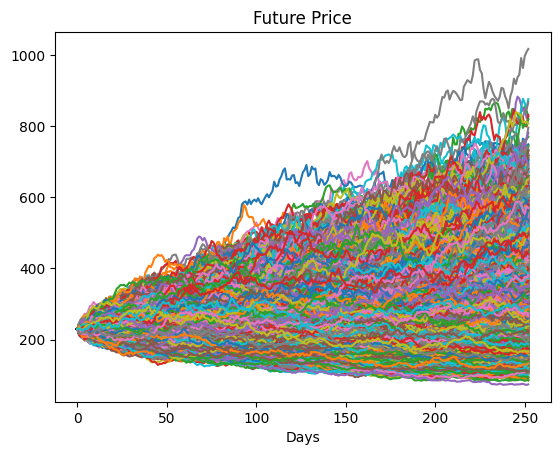

In [10]:
sim_df.plot(legend=False)
plt.title("Future Price")
plt.xlabel("Days")
plt.show()

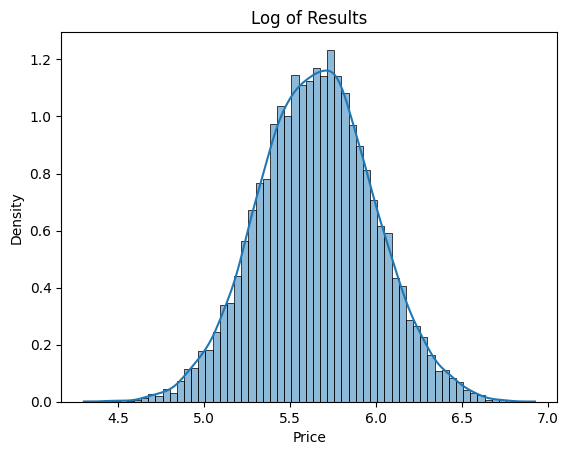

In [11]:
sns.histplot(np.log(results), kde= True, bins='auto', stat='density')
plt.title("Log of Results")
plt.xlabel("Price")
plt.show()

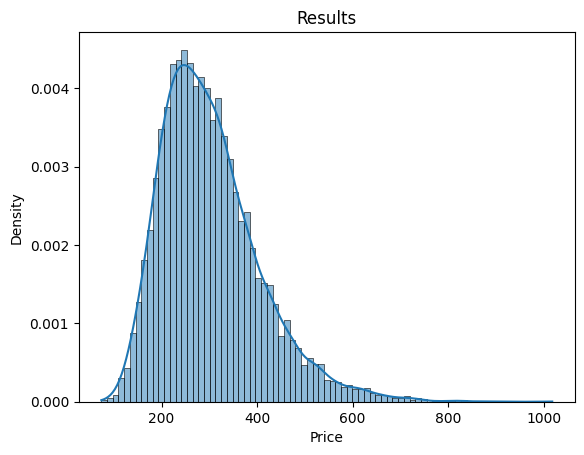

In [12]:
sns.histplot(results, kde= True, bins='auto', stat='density')
plt.title("Results")
plt.xlabel("Price")
plt.show()

# Analysis of Results
The following section offers a small analysis of the results. We first calculate the mean of the results, and we calculate the sample standard deviation of the results i.e. $Spread = S^2 = \frac{1}{n-1}\sum_{i = 1}^n (X_i - \bar{X})^2 $ where $X_i$ are the individual results.

It can be shown throw Slutsky's Theorem and the Central Limit Theorem that $\frac{\bar{X}-\mu}{\frac{S}{\sqrt{n}}}$ converges in distribution as n approaches infinity. We can then use this as an approximate pivot and use this to built a confidence interval for the actual expected value of the results.

In this, we also calculate the Maximum Likelihood Estimator of both the expected value and variance of the results. As an approaches infinity, the Maximum Likelihood Estimators are the stongest estimates for an unknown as they attain the Cramer-Rao Lower Bound. 
The MLE for the $\mu$ of Log-Normal Distribution is $\frac{1}{n}\sum_{i = 1}^{n} \ln{Y_i}$, where $Y_i$ are the individual results.
The MLE for $\sigma^2$ of a Log-Normal Distribution is $\frac{1}{n}\sum_{i = 1}^n (\ln{X_i} - \bar{X})^2 $. These are later used in approximations in probability estimation.

In [13]:
expected = np.mean(results)
spread = np.std(results, ddof=1)
clt_quant = norm.ppf(0.975)
mle_mu = np.mean(np.log(results))
mle_sigma = np.std(np.log(results))

In [14]:
print(f"Price at last close: {round(data['Close'][-1],2)}")
print(f"Expected: {round(expected,2)} Deviation: {round(spread,2)}")
print(f"Median: {round(np.median(results),2)} ; Q1: {round(np.percentile(results,25),2)}  ; Q3 {round(np.percentile(results,75),2)} ; IQR: {round(np.percentile(results,75) - np.percentile(results,25),2)}")
print("\n")
print(f"90% Confidence Interval for Outcome: [{round(np.percentile(results,5),2)},{round(np.percentile(results,95),2)}]")

clt_upper = round(expected + (spread/(n**(1/2))) * clt_quant , 2) # using (Xbar - mu) / (S/sqrt(n) as an approximate pivot for confidence intervals 
clt_lower = round(expected - (spread/(n**(1/2))) * clt_quant , 2)
print(f"95% Confidence Interval for Real Expected Value of outcome: [{clt_lower},{clt_upper}]")

Price at last close: 229.25
Expected: 302.32 Deviation: 103.73
Median: 286.05 ; Q1: 227.7  ; Q3 356.85 ; IQR: 129.15


90% Confidence Interval for Outcome: [166.0,495.41]
95% Confidence Interval for Real Expected Value of outcome: [300.29,304.36]


In [15]:
ProbabilityOver(results,data["Close"][-1],mle_mu,mle_sigma)
VaR_CVaR(results,mle_mu,mle_sigma,data["Close"][-1], r = 10)

Probabilty over last close (229.25) by count: 0.7434
Probabilty over last close (229.25) by Log Normal: 0.7462


Value at which 10% of predictions fall under by results: 187.72
Value at which 10% of predictions fall under by lognormal approximation: 186.47
Expected price of lower 10%: 161.19
Expected loss: 68.06


# Testing
In the next section, I run a small, simple test of the model. This includes getting data from 4 years back until one year prior to the date you are viewing. This 3 years of data is then used to run the model for the last year until today, and see were the closing price of today is in comparison to the models predictions. A graph is displayed for visualization showing the 90% confidence interval of the results and the 70% confidence interval of the results. The actual price path of the last year is also showed in the graph. Often times, the actual path is within the 70% confidence interval. 

In [17]:
inclusive_cutoff = new_data.index[-1]
test_sim_df = GBM(new_data, n, len(data.loc[inclusive_cutoff:]['Close'])-1)
test_results = np.array(test_sim_df.iloc[-1]) #lognormal dist
test_expected = np.mean(test_results)
test_spread = np.std(test_results)

print(f"Price at last close: {round(new_data['Close'][-1],2)}")
print(f"Expected: {round(test_expected,2)} Deviation: {round(test_spread,2)}")
print(f"Median: {round(np.median(test_results),2)} ; Q1: {round(np.percentile(test_results,25),2)}  ; Q3 {round(np.percentile(test_results,75),2)} ; IQR: {round(np.percentile(results,75) - np.percentile(results,25),2)}")
print(f"90% Confidence Interval for Outcome: [{round(np.percentile(test_results,5),2)},{round(np.percentile(test_results,95),2)}]")
print(f"70% Confidence Interval for Outcome: [{round(np.percentile(test_results,15),2)},{round(np.percentile(test_results,85),2)}]")
print(f"Actual Price today: {round(data['Close'][-1],2)}")

Price at last close: 188.39
Expected: 196.0 Deviation: 76.83
Median: 182.29 ; Q1: 141.34  ; Q3 236.18 ; IQR: 129.15
90% Confidence Interval for Outcome: [96.99,336.36]
70% Confidence Interval for Outcome: [123.44,269.81]
Actual Price today: 229.25


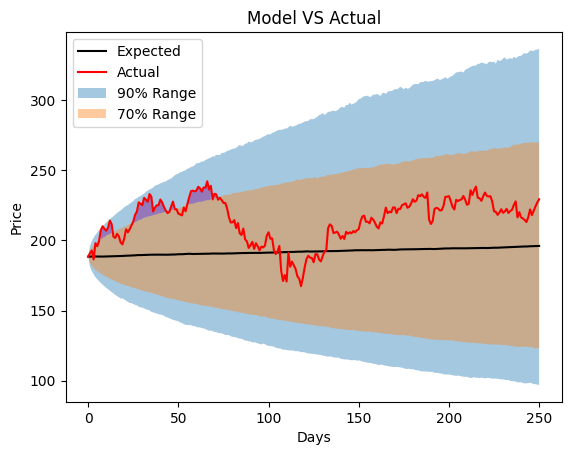

In [18]:
means = []
upper_90 = []
lower_90 = []
upper_70 = []
lower_70 = []

for i in range(len(test_sim_df.index)):
    means.append(np.mean(test_sim_df.iloc[i]))
    upper_90.append(np.percentile(test_sim_df.iloc[i],95))
    lower_90.append(np.percentile(test_sim_df.iloc[i],5))
    upper_70.append(np.percentile(test_sim_df.iloc[i],85))
    lower_70.append(np.percentile(test_sim_df.iloc[i],15))


fig, ax = plt.subplots()
ax.plot(range(len(means)),means, label = 'Expected', color = 'black')
ax.plot(range(len(means)),data.loc[inclusive_cutoff:]["Close"],label = 'Actual', color = 'red')

ax.fill_between(x = range(len(means)), y1=upper_90, y2=lower_90, alpha = .4, label = '90% Range')
ax.fill_between(range(len(means)), upper_90, data.loc[inclusive_cutoff:]["Close"], where= data.loc[inclusive_cutoff:]["Close"] > upper_90, fc='orange', alpha=0.4)
ax.fill_between(range(len(means)), lower_90, data.loc[inclusive_cutoff:]["Close"], where= data.loc[inclusive_cutoff:]["Close"] < lower_90, fc='orange', alpha=0.4)

ax.fill_between(x = range(len(means)), y1=upper_70, y2=lower_70, alpha = .4, label = '70% Range')
ax.fill_between(range(len(means)), upper_70, data.loc[inclusive_cutoff:]["Close"], where= data.loc[inclusive_cutoff:]["Close"] > upper_70, fc='purple', alpha=0.4)
ax.fill_between(range(len(means)), lower_70, data.loc[inclusive_cutoff:]["Close"], where= data.loc[inclusive_cutoff:]["Close"] < lower_70, fc='purple', alpha=0.4)

ax.set_title("Model VS Actual")
ax.set_xlabel("Days")
ax.set_ylabel("Price")
ax.legend(loc = 'upper left')
plt.show()

In [19]:
def get_jumps(log_changes):
    return [i for i in log_changes if abs(i - np.mean(log_changes)) > 3 * np.std(log_changes)]

def GBM_Jump(data,num,days, window = total):
    #There is the possibilty of 0 jumps in a certain window / if only one jump in period, all jumps will be of that size in model
    log_change = data["Log Change"][- window : ]
    jumps = get_jumps(log_change)
    print(f"There were {len(jumps)} jump(s) in the last {window} days.")

    mu = np.mean(log_change)
    std = np.std(log_change)
    

    if len(jumps) > 0:
        jump_mu = np.mean(jumps)
        jump_std = np.std(jumps)
    
        
        k = (m.e ** (jump_mu + (1/2) * jump_std ** 2)) - 1
        lam = len(jumps) / window

        drift = mu - (1/2) * (std ** 2) - lam * k

        # X = mu + sigma * Z where Z is N(0,1) gives N(mu,sigma^2)
        #delta_t = 1 as using daily increments and data for drift and volatility are daily closings
        z = np.random.normal(loc = drift, scale = std, size = (days,num))
        num_jumps = np.random.poisson(lam = lam , size= (days,num))
        jump_size = np.random.normal(loc = jump_mu, scale = jump_std, size=(days,num))
        jump_for_day = num_jumps * jump_size

        #to complete iteratively
        # for i in range(days):
        #     for j in range(num):
        #         z[i][j] = z[i][j] + np.sum(np.random.normal(loc = jump_mu, scale = jump_std, size = num_jumps[i][j]))
    
        z_updated = np.exp(z + jump_for_day)
        end = np.zeros(shape=(days+1,num))
        end[0] = data['Close'][-1]
        for i in range(1,days+1):
            end[i] = end[i-1] * z_updated[i-1] #Multiplying lognormal by lognormal produces lognormal
    
        return pd.DataFrame(end)
    elif len(jumps) == 0: #normal GBM if no jumps in given window
        drift = mu - (1/2) * (std ** 2)
        z_updated = np.exp(np.random.normal(loc = drift, scale = std, size = (days,num))) 
        end = np.zeros(shape=(days+1,num))
        end[0] = data['Close'][-1]
        for i in range(1,days+1):
            end[i] = end[i-1] * z_updated[i-1] #Multiplying lognormal by lognormal produces lognormal
    
        return pd.DataFrame(end)

In [20]:
jump_sim_df = GBM_Jump(data, n, trade_days)
jump_results = np.array(jump_sim_df.iloc[-1]) #lognormal dist
jump_expected = np.mean(jump_results)
jump_spread = np.std(jump_results, ddof=1)

jump_mle_mu = np.mean(np.log(jump_results))
jump_mle_sigma = np.std(np.log(jump_results)) 

There were 11 jump(s) in the last 1095 days.


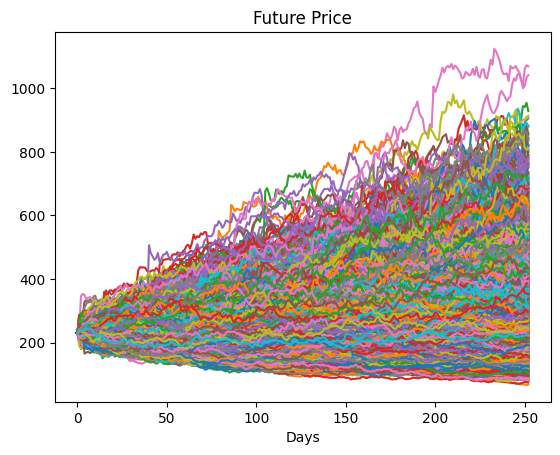

In [21]:
jump_sim_df.plot(legend=False)
plt.title("Future Price")
plt.xlabel("Days")
plt.show()

In [22]:
print(f"Price at last close: {round(data['Close'][-1],2)}")
print(f"Expected: {round(jump_expected,2)} Deviation: {round(jump_spread,2)}")
print(f"Median: {round(np.median(jump_results),2)} ; Q1: {round(np.percentile(jump_results,25),2)}  ; Q3 {round(np.percentile(jump_results,75),2)} ; IQR: {round(np.percentile(jump_results,75) - np.percentile(jump_results,25),2)}")
print("\n"*2)
print(f"90% Confidence Interval for Outcome: [{round(np.percentile(jump_results,5),2)},{round(np.percentile(jump_results,95),2)}]")

VaR_CVaR(jump_results,jump_mle_mu,jump_mle_sigma,data["Close"][-1], r = 10)

Price at last close: 229.25
Expected: 301.29 Deviation: 112.31
Median: 282.55 ; Q1: 221.45  ; Q3 359.28 ; IQR: 137.83



90% Confidence Interval for Outcome: [156.5,512.48]


Value at which 10% of predictions fall under by results: 178.65
Value at which 10% of predictions fall under by lognormal approximation: 177.88
Expected price of lower 10%: 151.73
Expected loss: 77.52


In [23]:
print("Statistics for GBM:")
print(f"Expected: {round(expected,2)} Deviation: {round(spread,2)}")
print(f"Median: {round(np.median(results),2)} ; Q1: {round(np.percentile(results,25),2)}  ; Q3 {round(np.percentile(results,75),2)} ; IQR: {round(np.percentile(results,75) - np.percentile(results,25),2)}")
print(f"90% Confidence Interval for Outcome: [{round(np.percentile(results,5),2)},{round(np.percentile(results,95),2)}]")
print(f"Kurtosis: {st.kurtosis(results)}")

print("\nStatistics for Jump Diffusion")
print(f"Expected: {round(jump_expected,2)} Deviation: {round(jump_spread,2)}")
print(f"Median: {round(np.median(jump_results),2)} ; Q1: {round(np.percentile(jump_results,25),2)}  ; Q3 {round(np.percentile(jump_results,75),2)} ; IQR: {round(np.percentile(jump_results,75) - np.percentile(jump_results,25),2)}")
print(f"90% Confidence Interval for Outcome: [{round(np.percentile(jump_results,5),2)},{round(np.percentile(jump_results,95),2)}]")
print(f"Kurtosis: {st.kurtosis(jump_results)}")

Statistics for GBM:
Expected: 302.32 Deviation: 103.73
Median: 286.05 ; Q1: 227.7  ; Q3 356.85 ; IQR: 129.15
90% Confidence Interval for Outcome: [166.0,495.41]
Kurtosis: 1.7490079376298233

Statistics for Jump Diffusion
Expected: 301.29 Deviation: 112.31
Median: 282.55 ; Q1: 221.45  ; Q3 359.28 ; IQR: 137.83
90% Confidence Interval for Outcome: [156.5,512.48]
Kurtosis: 2.317598913604561


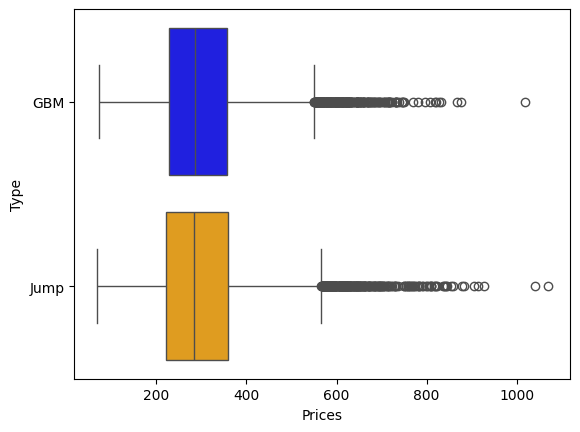

In [24]:
df = pd.concat([pd.DataFrame({"Prices" : results, "Type": ['GBM' for _ in range(len(results))]}), pd.DataFrame({"Prices" : jump_results, "Type": ['Jump' for _ in range(len(results))]})])
bxplt = sns.boxplot(data = df , x = 'Prices', y = 'Type', hue = 'Type', palette = ['b','orange'],legend = False)
plt.show()

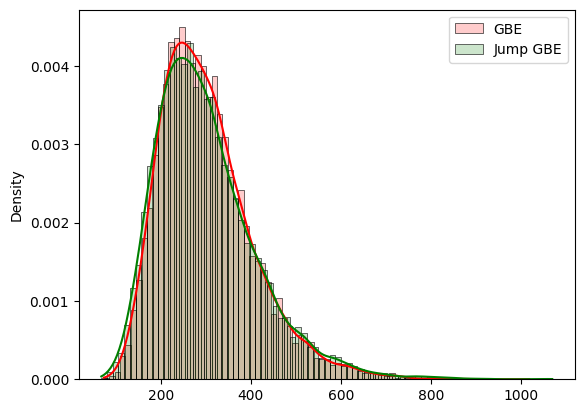

In [25]:
sns.histplot(data= results, color = 'Red', alpha = .2, kde=True, label ='GBE', stat= 'density')
sns.histplot(data= jump_results, color = 'Green', alpha = .2, kde=True, label ='Jump GBE', stat= 'density')

plt.legend()
plt.show()